In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/KaggleAPI ~/.kaggle/

cp: -r not specified; omitting directory '/content/drive/MyDrive/KaggleAPI'


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download ninadaithal/imagesoasis

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
100% 1.23G/1.23G [01:00<00:00, 25.0MB/s]
100% 1.23G/1.23G [01:01<00:00, 21.7MB/s]


In [ ]:
! unzip imagesoasis.zip

In [ ]:
import os
import tensorflow as tf
import keras
from keras.utils import load_img
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

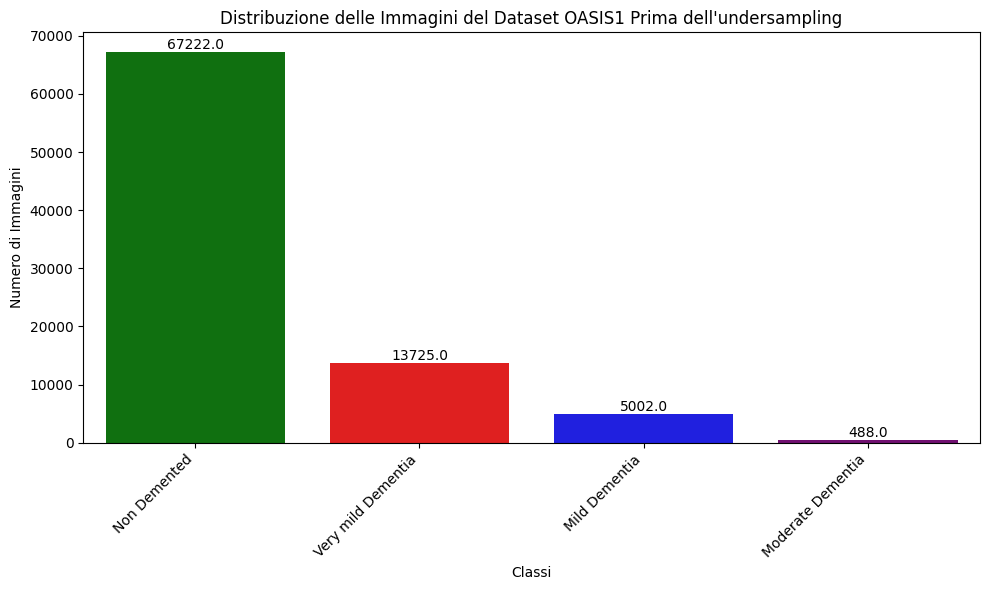

In [ ]:
dataset_path = '/content/Data'

data = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    num_images = len(os.listdir(folder_path))
    data.append((num_images, folder))


df = pd.DataFrame(data, columns=['Num of Images', 'Class'])


class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']


palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}



plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class', y='Num of Images', hue=df['Class'], data=df, palette=palette, order=class_order)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 0),
                textcoords='offset points')

plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Immagini del Dataset OASIS1 Prima dell\'undersampling')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
dataset_path = '/content/Data'
very_mild_demented_path = os.path.join(dataset_path, 'Very mild Dementia')
non_demented_path = os.path.join(dataset_path, 'Non Demented')

num_elements = len(os.listdir(very_mild_demented_path))
print('Numero di elementi di classe Very Mild Demented prima dell\'undersampling: ' + str(num_elements))

num_elements = len(os.listdir(non_demented_path))
print('Numero di elementi di classe Non Demented prima dell\'undersampling: ' + str(num_elements))

i=0
for image in os.listdir(very_mild_demented_path):
    if i > 5001:
        image_path = os.path.join(very_mild_demented_path, image)
        os.remove(image_path)
        i = i+1
    else:
        i=i+1

num_elements = len(os.listdir(very_mild_demented_path))
print('Numero di elementi di classe Very Mild Demented a seguito dell\'undersampling: ' + str(num_elements))



i=0
for image in os.listdir(non_demented_path):
    if i > 5001:
        image_path = os.path.join(non_demented_path, image)
        os.remove(image_path)
        i = i+1
    else:
        i=i+1

num_elements = len(os.listdir(non_demented_path))
print('Numero di elementi di classe Non Demented a seguito dell\'undersampling: ' + str(num_elements))

Numero di elementi di classe Very Mild Demented prima dell'undersampling: 13725
Numero di elementi di classe Non Demented prima dell'undersampling: 67222
Numero di elementi di classe Very Mild Demented a seguito dell'undersampling: 5002
Numero di elementi di classe Non Demented a seguito dell'undersampling: 5002


In [ ]:
dataset_path = '/content/Data'

images = []
labels = []
groups = []

i=0
j=0

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        images.append(image_path)
        labels.append(folder)


        if i == 60:
            i=-1
            groups.append(j)
            j=j+1
        else:
            groups.append(j)

        i=i+1




images = np.array(images)
labels = np.array(labels)
groups = np.array(groups)

df = pd.DataFrame({'images': images, 'labels': labels, 'groups': groups})

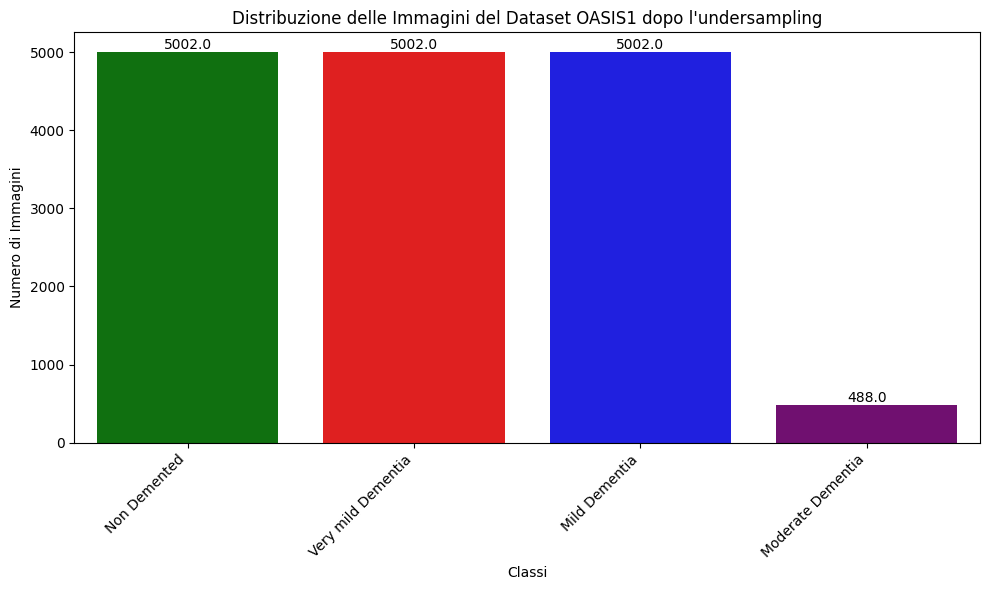

In [ ]:
dataset_path = '/content/Data'

data = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    num_images = len(os.listdir(folder_path))
    data.append((num_images, folder))


df = pd.DataFrame(data, columns=['Num of Images', 'Class'])

class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class', y='Num of Images', hue=df['Class'], data=df, palette=palette, order=class_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 0),
                textcoords='offset points')

plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Immagini del Dataset OASIS1 dopo l\'undersampling')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_index, test_index = next(gss.split(images, labels, groups=groups))


group_train = groups[train_index]
group_test = groups[test_index]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=2)
train_index_final, val_index = next(gss_val.split(images[train_index], labels[train_index], groups=group_train))


train_index_final = train_index[train_index_final]
val_index = train_index[val_index]

group_train_final = groups[train_index_final]
group_val = groups[val_index]

X_train = images[train_index_final]
y_train = labels[train_index_final]

X_val = images[val_index]
y_val = labels[val_index]


X_test = images[test_index]
y_test = labels[test_index]

In [ ]:
train_df = pd.DataFrame({'images': X_train, 'labels': y_train})
val_df = pd.DataFrame({'images': X_val, 'labels': y_val})
test_df = pd.DataFrame({'images': X_test, 'labels': y_test})


train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2],
    width_shift_range=0.05,
    height_shift_range=0.05
)


test_val_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='images', y_col='labels', target_size=(496,248), batch_size=9272, class_mode='categorical'
)

train_data, train_labels = next(train_generator)
print(train_data.shape, train_labels.shape)

Found 9272 validated image filenames belonging to 4 classes.
(9272, 496, 248, 3) (9272, 4)


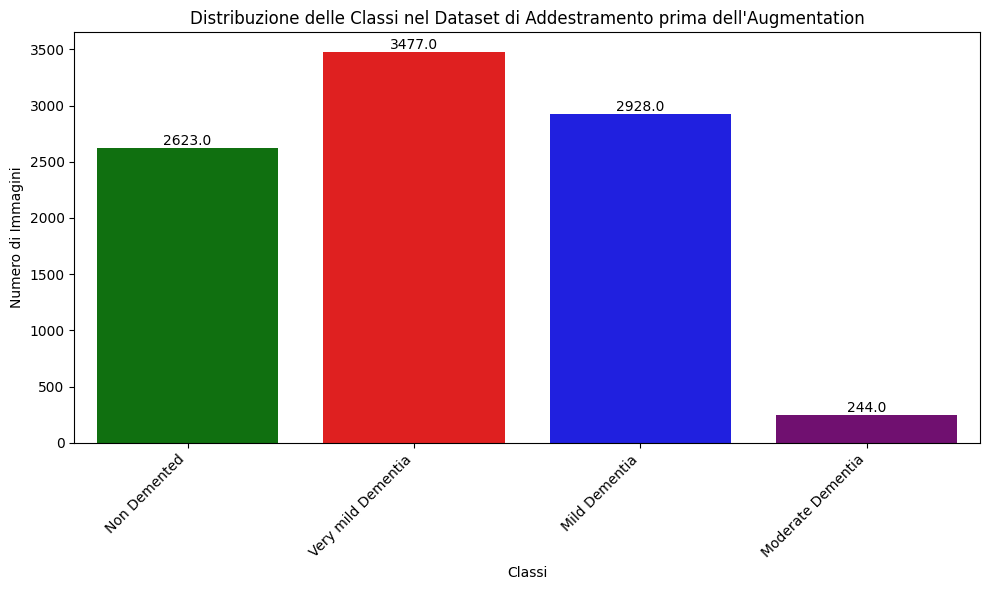

In [ ]:
train_labels_classes = np.argmax(train_labels, axis=1)
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
labels_mapped = [class_labels[label] for label in train_labels_classes]

class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}


plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_mapped, hue=labels_mapped, palette=palette, order=class_order, legend=False)
plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Classi nel Dataset di Addestramento prima dell\'Augmentation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 496 * 248 * 3), train_labels)
train_data = train_data.reshape(-1, 496,248, 3)
print(train_data.shape, train_labels.shape)

(13908, 496, 248, 3) (13908, 4)


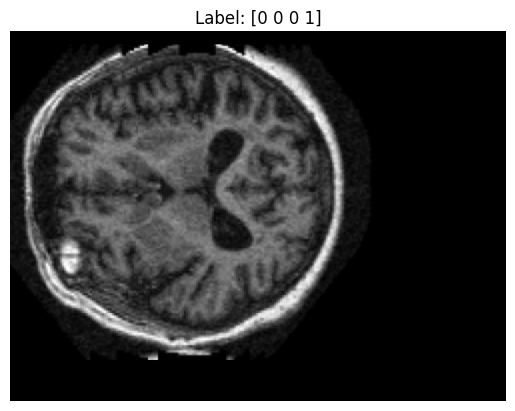

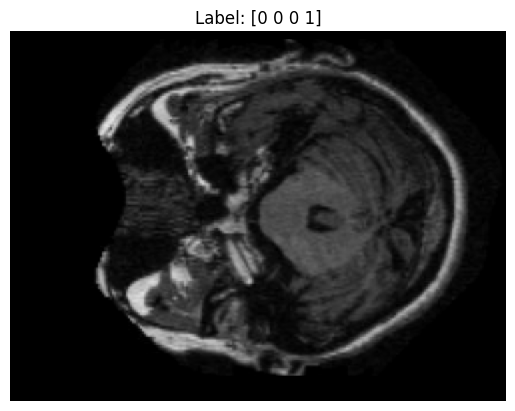

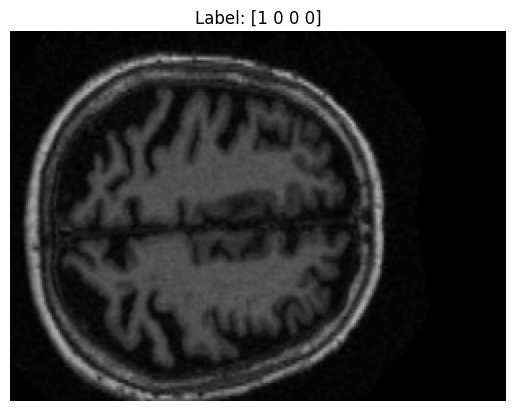

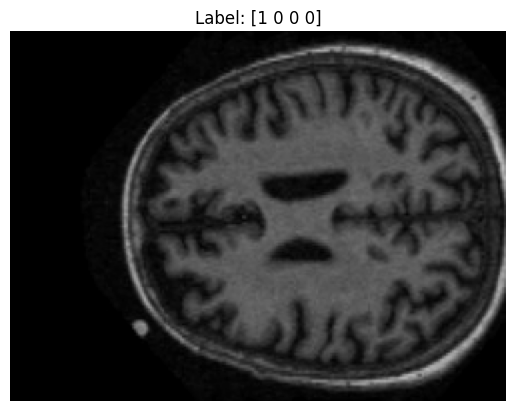

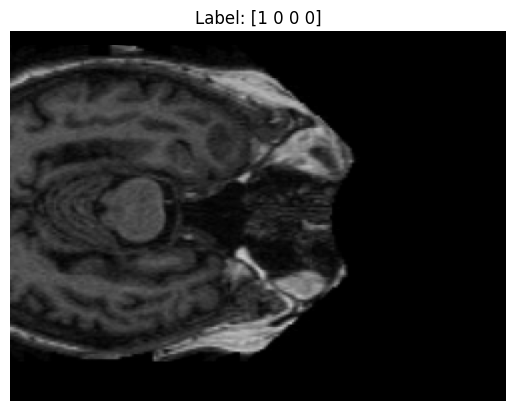

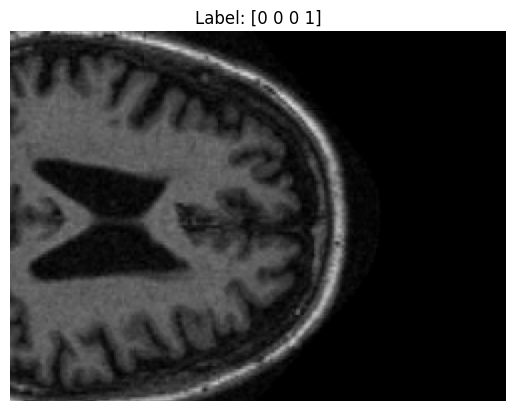

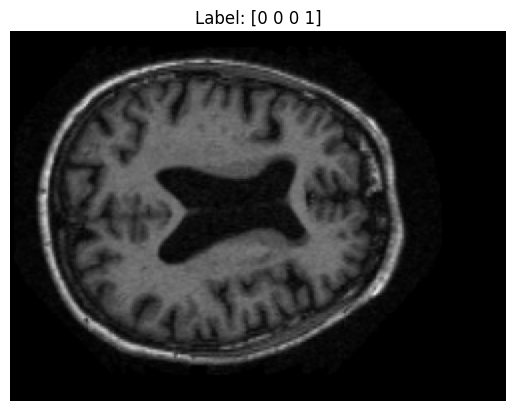

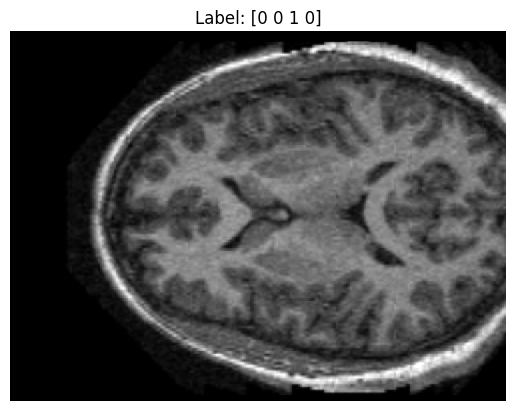

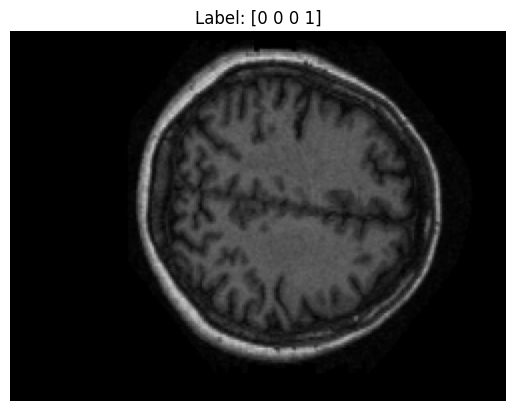

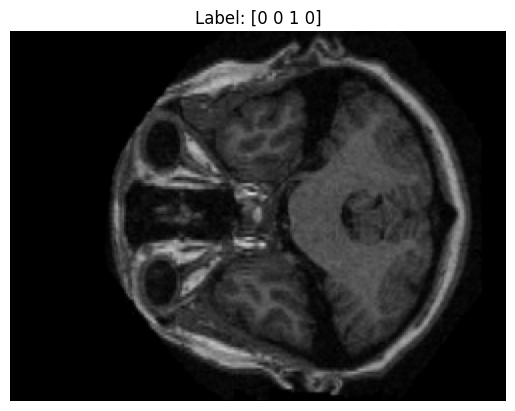

In [ ]:
for i in range(10):

    plt.imshow(train_data[i], aspect='auto')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
    plt.show()

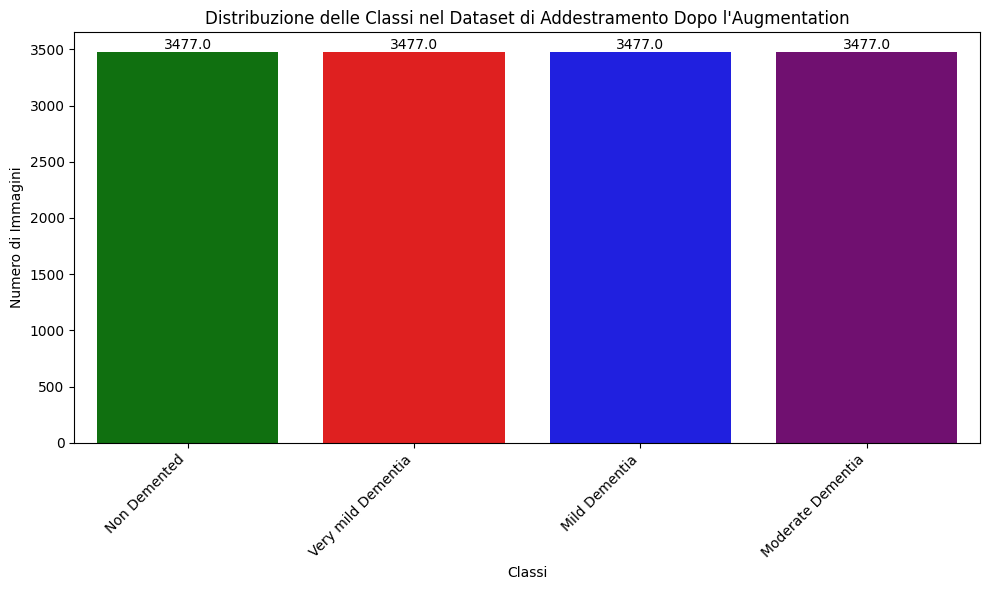

In [ ]:

train_labels_classes = np.argmax(train_labels, axis=1)
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())
labels_mapped = [class_labels[label] for label in train_labels_classes]

class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}


plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_mapped, hue=labels_mapped, legend=False, palette=palette, order=class_order)
plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Classi nel Dataset di Addestramento Dopo l\'Augmentation')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
val_generator = test_val_datagen.flow_from_dataframe(
    val_df, x_col='images', y_col='labels', target_size=(496,248), batch_size=3111, class_mode='categorical'
)


val_data, val_labels = next(val_generator)

print(val_data.shape, val_labels.shape)

Found 3111 validated image filenames belonging to 4 classes.
(3111, 496, 248, 3) (3111, 4)


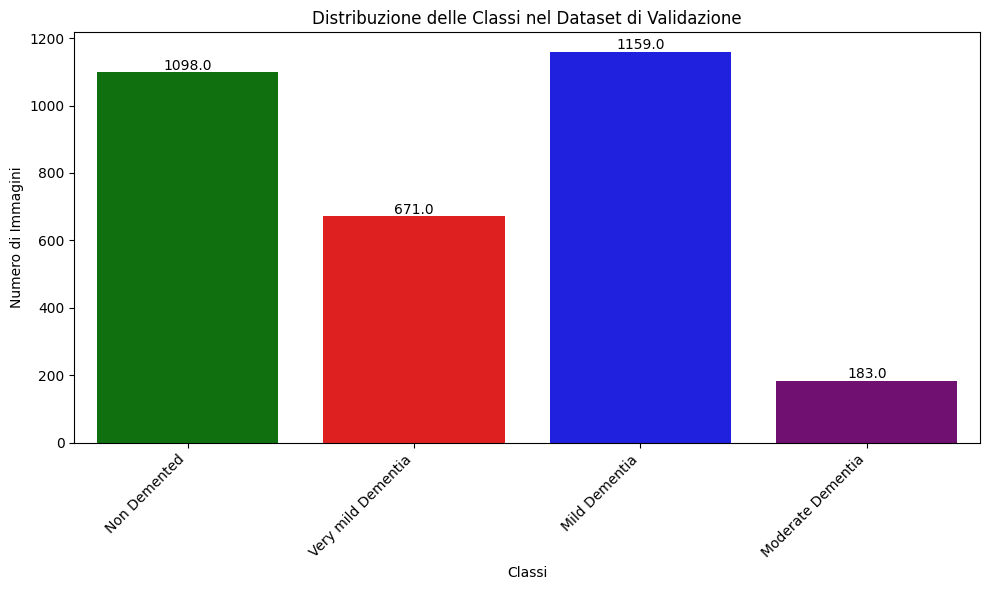

In [ ]:
val_labels_classes = np.argmax(val_labels, axis=1)
class_indices = val_generator.class_indices
class_labels = list(class_indices.keys())
labels_mapped = [class_labels[label] for label in val_labels_classes]

class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}



plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_mapped, hue=labels_mapped, legend=False, palette=palette, order=class_order)
plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Classi nel Dataset di Validazione')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(496, 248, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss = 'categorical_crossentropy',optimizer = 'Adamax',metrics=['accuracy'])

print(model.summary())


es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=10, restore_best_weights=True,)
rlr = ReduceLROnPlateau(monitor="val_loss", patience=3)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 496, 248, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 247, 123, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 247, 123, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 247, 123, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 245, 121, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 245, 121, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 245, 121, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 245, 121, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 245, 121, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 245, 121, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 122, 60, 64)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 122, 60, 80)    │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 122, 60, 80)    │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 122, 60, 80)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 120, 58, 192)   │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 120, 58, 192)   │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 23,870,628 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model).show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 33.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(val_data,val_labels),
    epochs=100,
    batch_size=32,
    callbacks = [es, rlr]
)

Epoch 1/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 195s 252ms/step - accuracy: 0.6692 - loss: 0.8202 - val_accuracy: 0.7515 - val_loss: 0.7264 - learning_rate: 0.0010
Epoch 2/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.8850 - loss: 0.2955 - val_accuracy: 0.8852 - val_loss: 0.3056 - learning_rate: 0.0010
Epoch 3/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9306 - loss: 0.1837 - val_accuracy: 0.6255 - val_loss: 1.7387 - learning_rate: 0.0010
Epoch 4/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9523 - loss: 0.1413 - val_accuracy: 0.7306 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 5/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9625 - loss: 0.0987 - val_accuracy: 0.9145 - val_loss: 0.2904 - learning_rate: 0.0010
Epoch 6/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9812 - loss: 0.0558 - val_accuracy: 0.8521 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 7/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0

In [ ]:
test_generator = test_val_datagen.flow_from_dataframe(
    test_df, x_col='images', y_col='labels', target_size=(496,248), batch_size=3111, class_mode='categorical'
)
test_data, test_labels = next(test_generator)

print(test_data.shape, test_labels.shape)

Found 3111 validated image filenames belonging to 4 classes.
(3111, 496, 248, 3) (3111, 4)


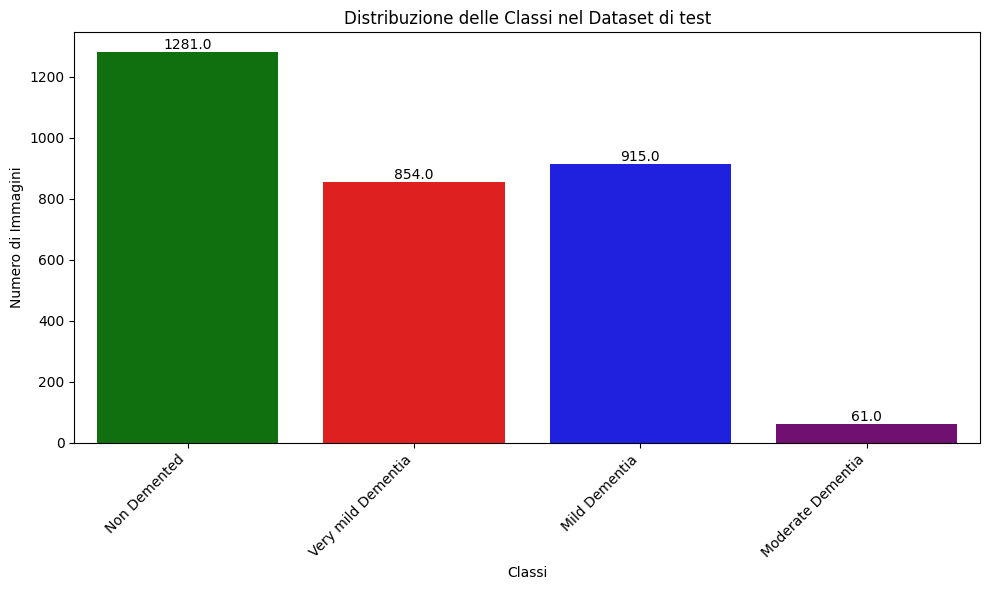

In [ ]:
test_labels_classes = np.argmax(test_labels, axis=1)
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())
labels_mapped = [class_labels[label] for label in test_labels_classes]

class_order = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
palette = {
    'Non Demented': 'green',
    'Mild Dementia': 'blue',
    'Moderate Dementia': 'purple',
    'Very mild Dementia': 'red'
}



plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_mapped, hue=labels_mapped, legend=False, palette=palette, order=class_order)
plt.xlabel('Classi')
plt.ylabel('Numero di Immagini')
plt.title('Distribuzione delle Classi nel Dataset di test')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("Evaluate")
result = model.evaluate(test_data,test_labels)

Evaluate
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9460 - loss: 0.2082


In [ ]:
model.save('/content/drive/MyDrive/final-model.keras')

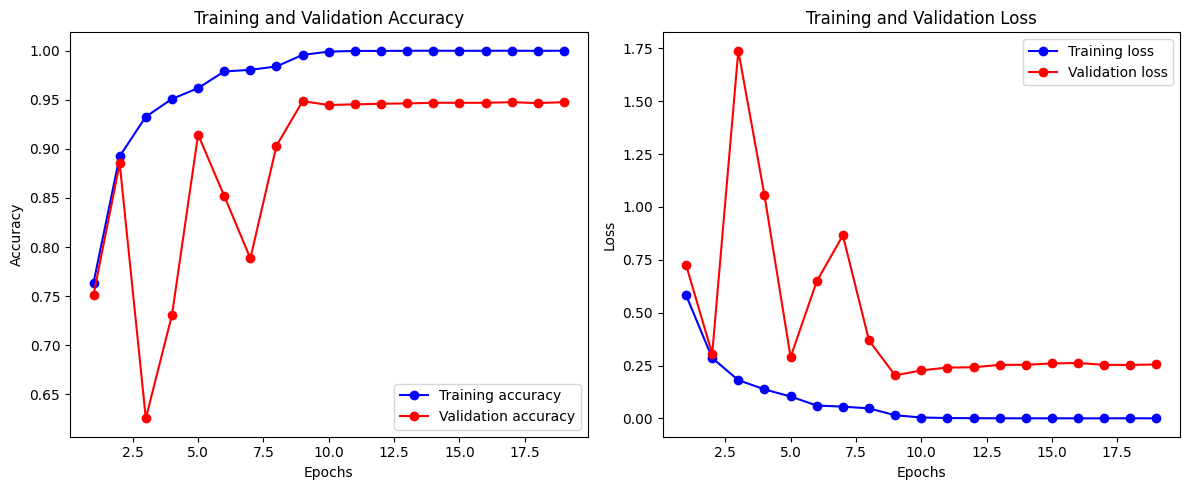

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Grafico di accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Grafico di loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Matrice di confusione:
 [[1157  108   16    0]
 [  33  811   10    0]
 [   3    4  908    0]
 [   0    0    0   61]]


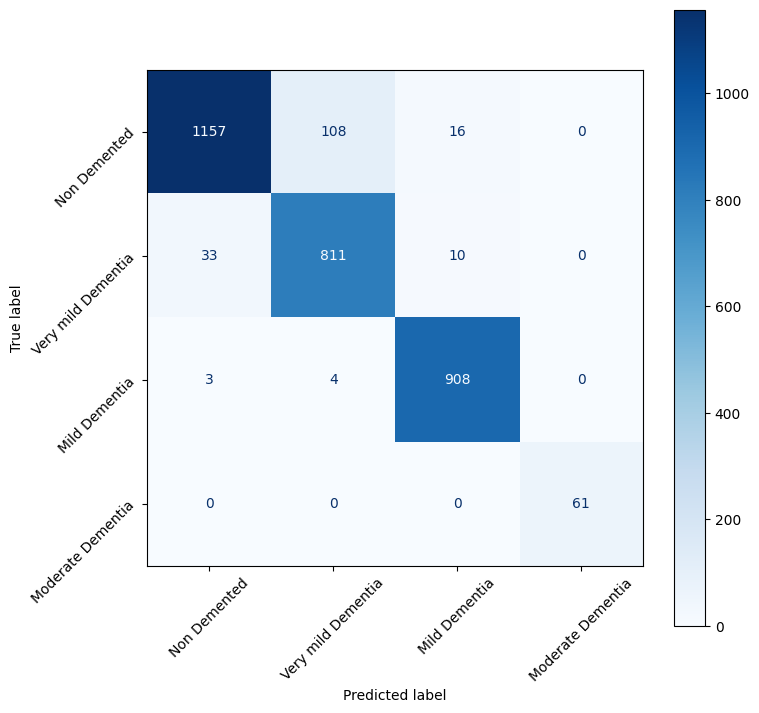

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)


y_test_classes = np.argmax(test_labels, axis=1)


cm = confusion_matrix(y_test_classes, y_pred_classes, labels=[2, 3, 0, 1])


print("Matrice di confusione:\n", cm)



labels = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()